In [16]:
from kloppy import skillcorner
import pandas as pd
import numpy as np

import requests
import json

# import mplsoccer 
# Setup pitch and plot
from mplsoccer import Pitch, VerticalPitch

In [17]:
match_id = 1886347

dataset = skillcorner.load_open_data(
    match_id=match_id,    # Optional Parameters
    coordinates="skillcorner",  # or specify a different coordinate system
    sample_rate= (1/2),  # changes the data from 10fps to 5fps
    limit=100,  # only load the first 100 frames
)

In [18]:
type(dataset)

kloppy.domain.models.tracking.TrackingDataset

In [19]:
df = (
    dataset.transform(to_orientation="STATIC_HOME_AWAY")  # Now, all attacks happen from left to right
    .filter(lambda frame: frame.period.id == 1)  # Only keep frames from the first half
    .to_df(engine="polars")  # Convert to a Polars DataFrame, or use engine="pandas" for a Pandas DataFrame
)

## Using the Raw Data Pull (SkillCorner Tutorials)

In [20]:
match_id = 1886347
# Construct the raw GitHub URL
tracking_url = f"https://media.githubusercontent.com/media/SkillCorner/opendata/master/data/matches/{match_id}/{match_id}_tracking_extrapolated.jsonl"
raw_data = pd.read_json(tracking_url, lines=True)


In [21]:
raw_data.iloc[10,:]

frame                                                                      10
timestamp                                                 2025-12-04 00:00:00
period                                                                    1.0
ball_data                   {'x': 0.32, 'y': 0.38, 'z': 0.13, 'is_detected...
possession                                 {'player_id': None, 'group': None}
image_corners_projection    {'x_top_left': -52.52, 'y_top_left': 39.0, 'x_...
player_data                 [{'x': -39.63, 'y': -0.08, 'player_id': 51009,...
Name: 10, dtype: object

In [22]:
# Transform the data to observation level data that we can further manipulate for future analysis
raw_df = pd.json_normalize(
    raw_data.to_dict("records"),
    "player_data",
    ["frame", "timestamp", "period", "possession", "ball_data"],
)

display(raw_df.shape)
raw_df.head()

(956076, 9)

,x,y,player_id,is_detected,frame,timestamp,period,possession,ball_data
0,-39.63,-0.08,51009,False,10,2025-12-04,1.0,"{'player_id': None, 'group': None}","{'x': 0.32, 'y': 0.38, 'z': 0.13, 'is_detected..."
1,-19.21,-9.18,176224,True,10,2025-12-04,1.0,"{'player_id': None, 'group': None}","{'x': 0.32, 'y': 0.38, 'z': 0.13, 'is_detected..."
2,-21.83,0.47,51649,True,10,2025-12-04,1.0,"{'player_id': None, 'group': None}","{'x': 0.32, 'y': 0.38, 'z': 0.13, 'is_detected..."
3,-1.16,-32.47,50983,True,10,2025-12-04,1.0,"{'player_id': None, 'group': None}","{'x': 0.32, 'y': 0.38, 'z': 0.13, 'is_detected..."
4,-18.88,15.73,735578,True,10,2025-12-04,1.0,"{'player_id': None, 'group': None}","{'x': 0.32, 'y': 0.38, 'z': 0.13, 'is_detected..."


In [23]:
# Extract 'player_id' and 'group from the 'possession' column which is a dictionary in the dataframe
raw_df["possession_player_id"] = raw_df["possession"].apply(lambda x : x.get("player_id"))
raw_df["possession_group"] = raw_df["possession"].apply(lambda x : x.get("group"))

raw_df.head(3)

,x,y,player_id,is_detected,frame,timestamp,period,possession,ball_data,possession_player_id,possession_group
0,-39.63,-0.08,51009,False,10,2025-12-04,1.0,"{'player_id': None, 'group': None}","{'x': 0.32, 'y': 0.38, 'z': 0.13, 'is_detected...",NaN,None
1,-19.21,-9.18,176224,True,10,2025-12-04,1.0,"{'player_id': None, 'group': None}","{'x': 0.32, 'y': 0.38, 'z': 0.13, 'is_detected...",NaN,None
2,-21.83,0.47,51649,True,10,2025-12-04,1.0,"{'player_id': None, 'group': None}","{'x': 0.32, 'y': 0.38, 'z': 0.13, 'is_detected...",NaN,None


In [24]:
# (Optional) Expand the ball_data with json_normalize
# This gives us the coordinates of the ball!
raw_df[["ball_x", "ball_y", "ball_z", "is_detected_ball"]] = pd.json_normalize(raw_df.ball_data)
raw_df.head(1)

,x,y,player_id,is_detected,frame,timestamp,period,possession,ball_data,possession_player_id,possession_group,ball_x,ball_y,ball_z,is_detected_ball
0,-39.63,-0.08,51009,False,10,2025-12-04,1.0,"{'player_id': None, 'group': None}","{'x': 0.32, 'y': 0.38, 'z': 0.13, 'is_detected...",NaN,None,0.32,0.38,0.13,True


In [25]:
raw_df["possession_player_id"].isna().sum() # not all observations will involve a possession id since they might not be in possesion

np.int64(725362)

In [26]:
# (Optional) Drop the original 'possession' column if you no longer need it
raw_df = raw_df.drop(columns=["possession", "ball_data"])

# Add the match_id identifier to your dataframe
raw_df["match_id"] = match_id
tracking_df = raw_df.copy()
tracking_df.head()

del raw_df

In [27]:
tracking_df.head(5)

,x,y,player_id,is_detected,frame,timestamp,period,possession_player_id,possession_group,ball_x,ball_y,ball_z,is_detected_ball,match_id
0,-39.63,-0.08,51009,False,10,2025-12-04,1.0,NaN,None,0.32,0.38,0.13,True,1886347
1,-19.21,-9.18,176224,True,10,2025-12-04,1.0,NaN,None,0.32,0.38,0.13,True,1886347
2,-21.83,0.47,51649,True,10,2025-12-04,1.0,NaN,None,0.32,0.38,0.13,True,1886347
3,-1.16,-32.47,50983,True,10,2025-12-04,1.0,NaN,None,0.32,0.38,0.13,True,1886347
4,-18.88,15.73,735578,True,10,2025-12-04,1.0,NaN,None,0.32,0.38,0.13,True,1886347


### Get Metadata

In [28]:
def time_to_seconds(time_str):
    if time_str is None:
        return 90 * 60  # 120 minutes = 7200 seconds
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

In [29]:
match_id = 1886347
meta_data_github_url = f"https://raw.githubusercontent.com/SkillCorner/opendata/master/data/matches/{match_id}/{match_id}_match.json"
# Read the JSON data as a JSON object
response = requests.get(meta_data_github_url)
raw_match_data = response.json()

# The output has nested json elements. We process them
raw_match_df = pd.json_normalize(raw_match_data, max_level=2)
raw_match_df["home_team_side"] = raw_match_df["home_team_side"].astype(str)
raw_match_df.head(1)

,id,home_team_score,away_team_score,date_time,home_team_coach,away_team_coach,match_periods,referees,players,status,...,competition_edition.season.id,competition_edition.season.start_year,competition_edition.season.end_year,competition_edition.season.name,competition_edition.name,competition_round.id,competition_round.name,competition_round.round_number,competition_round.potential_overtime,ball.trackable_object
0,1886347,2,0,2024-11-30T04:00:00Z,None,None,"[{'period': 1, 'name': 'period_1', 'start_fram...",[],"[{'player_role': {'id': 15, 'position_group': ...",closed,...,95,2024,2025,2024/2025,AUS - A-League - 2024/2025,611,Round 6,6,False,55


In [30]:
players_df = pd.json_normalize(
    raw_match_df.to_dict("records"), 
    record_path="players", 
    meta=[
        "home_team_score",
        "away_team_score",
        "date_time",
        "home_team_side",
        "home_team.name",
        "home_team.id",
        "away_team.name",
        "away_team.id",
    ],  # data we keep
)

# Take only players who played and create their total time
players_df = players_df[~((players_df.start_time.isna()) & (players_df.end_time.isna()))] # filter for players who have played
players_df["total_time"] = players_df["end_time"].apply(time_to_seconds) - players_df["start_time"].apply(time_to_seconds) # calculating playing time
# players_df["total_time_mins"] = (players_df["total_time"] * 1.0) / 60.0

# Create a flag for GK
players_df["is_gk"] = players_df["player_role.acronym"] == "GK" # create a boolean that lets us know if the player is a GK

# Create a match name variable
players_df["match_name"] = (players_df["home_team.name"] + " vs " + players_df["away_team.name"]) # create the name of the match

# Add a flag if the given player is home or away
players_df["home_away_player"] = np.where(players_df.team_id == players_df["home_team.id"], "Home", "Away") # Categorical

# Create flag from player
players_df["team_name"] = np.where(players_df.team_id == players_df["home_team.id"], players_df["home_team.name"], players_df["away_team.name"],)

# Figure out sides
players_df[["home_team_side_1st_half", "home_team_side_2nd_half"]] = (
    players_df["home_team_side"]
    .astype(str)
    .str.strip("[]")
    .str.replace("'", "")
    .str.split(", ", expand=True)
)

# Clean up sides
players_df["direction_player_1st_half"] = np.where(
    players_df.home_away_player == "Home",
    players_df.home_team_side_1st_half,
    players_df.home_team_side_2nd_half,
)
players_df["direction_player_2nd_half"] = np.where(
    players_df.home_away_player == "Home",
    players_df.home_team_side_2nd_half,
    players_df.home_team_side_1st_half,
)

players_df["match_id"] = match_id

# Clean up and keep the columns that we want to keep for our metadata

columns_to_keep = [
    "start_time",
    "end_time",
    "match_name",
    "match_id",
    "date_time",
    "home_team.name",
    "away_team.name",
    "id",
    "short_name",
    "number",
    "team_id",
    "team_name",
    "player_role.position_group",
    "total_time",
    "player_role.name",
    "player_role.acronym",
    "is_gk",
    "direction_player_1st_half",
    "direction_player_2nd_half",
]
players_df = players_df[columns_to_keep]
players_df.head(3)

,start_time,end_time,match_name,match_id,date_time,home_team.name,away_team.name,id,short_name,number,team_id,team_name,player_role.position_group,total_time,player_role.name,player_role.acronym,is_gk,direction_player_1st_half,direction_player_2nd_half
0,00:00:00,01:25:21,Auckland FC vs Newcastle United Jets FC,1886347,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,38673,G. May,10,4177,Auckland FC,Center Forward,5121,Center Forward,CF,False,right_to_left,left_to_right
1,00:00:00,None,Auckland FC vs Newcastle United Jets FC,1886347,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,51713,C. Elliott,17,4177,Auckland FC,Full Back,5400,Right Back,RB,False,right_to_left,left_to_right
2,00:00:00,01:16:37,Auckland FC vs Newcastle United Jets FC,1886347,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,50951,J. Brimmer,22,4177,Auckland FC,Center Forward,4597,Center Forward,CF,False,right_to_left,left_to_right


In [31]:
# Merging datasets
enriched_tracking_data = tracking_df.merge(
    players_df, left_on=["player_id", "match_id"], right_on=["id", "match_id"]
)
enriched_tracking_data.head()

,x,y,player_id,is_detected,frame,timestamp,period,possession_player_id,possession_group,ball_x,...,number,team_id,team_name,player_role.position_group,total_time,player_role.name,player_role.acronym,is_gk,direction_player_1st_half,direction_player_2nd_half
0,-39.63,-0.08,51009,False,10,2025-12-04,1.0,NaN,None,0.32,...,1,1805,Newcastle United Jets FC,Other,5400,Goalkeeper,GK,True,left_to_right,right_to_left
1,-19.21,-9.18,176224,True,10,2025-12-04,1.0,NaN,None,0.32,...,4,1805,Newcastle United Jets FC,Central Defender,5400,Right Center Back,RCB,False,left_to_right,right_to_left
2,-21.83,0.47,51649,True,10,2025-12-04,1.0,NaN,None,0.32,...,15,1805,Newcastle United Jets FC,Central Defender,5400,Left Center Back,LCB,False,left_to_right,right_to_left
3,-1.16,-32.47,50983,True,10,2025-12-04,1.0,NaN,None,0.32,...,14,1805,Newcastle United Jets FC,Full Back,5400,Right Back,RB,False,left_to_right,right_to_left
4,-18.88,15.73,735578,True,10,2025-12-04,1.0,NaN,None,0.32,...,33,1805,Newcastle United Jets FC,Full Back,5400,Left Back,LB,False,left_to_right,right_to_left


In [19]:
# Filtering for frames with a team in possession
filtered_df = enriched_tracking_data[enriched_tracking_data["possession_group"].notnull()].copy()

# We basically want to convert the X and Y to make sure we're always visualizing left to right. A player's XY will depend on the half so the straight average doesn't work
filtered_df["direction_player"] = np.where(
    filtered_df["period"] == 1,
    filtered_df["direction_player_1st_half"],
    filtered_df["direction_player_2nd_half"],
)
# When going right to left, we flip the coordinates (We want our analysis to go from left to right)
filtered_df["x"] = np.where(
    filtered_df["direction_player"] == "right_to_left",
    -filtered_df["x"], # when going right to left, flip coordinates
    filtered_df["x"],
)  # Convert X

filtered_df["y"] = np.where(
    filtered_df["direction_player"] == "right_to_left",
    -filtered_df["y"], # when going right to left, flip coordinates
    filtered_df["y"],
)  # Convert Y

# Create some flags in case we need them later
filtered_df["possession_team_name"] = np.where(
    filtered_df["possession_group"] == "home team",
    filtered_df["home_team.name"],
    filtered_df["away_team.name"],
)

filtered_df["possession_flag"] = np.where(
    filtered_df["possession_team_name"] == filtered_df["team_name"], 
    "IP", # In Possession
    "OOP" # Out of Possession
)

# At this point all of our players have their X and Y adjusted from left to right , so we can aggregate for across the game to get their average position during the game
aggregated_df = (
    filtered_df.groupby(
        [
            "player_id",
            "possession_group",
            "team_name",
            "possession_team_name",
            "possession_flag",  # This will allow us to check the position of the player when the team is in or out of possession
            "start_time",  # With this we can filter in or out the players that came on as subs
            "number",
            "is_gk",
        ]
    )[["x", "y"]]
    .mean()
    .reset_index()
)

aggregated_df.sort_values(["possession_flag", "team_name"]).head(5)

,player_id,possession_group,team_name,possession_team_name,possession_flag,start_time,number,is_gk,x,y
1,14736,home team,Auckland FC,Auckland FC,IP,00:00:00,6,False,5.181767,-4.093078
3,23418,home team,Auckland FC,Auckland FC,IP,00:00:00,28,False,7.095420,8.334144
5,31147,home team,Auckland FC,Auckland FC,IP,01:25:21,5,False,-9.197614,0.121759
7,33697,home team,Auckland FC,Auckland FC,IP,00:00:00,4,False,-6.836360,8.199158
9,38673,home team,Auckland FC,Auckland FC,IP,00:00:00,10,False,21.607955,-0.350817


Text(0.5, 1.0, 'Auckland FC Average Positions in Possession')

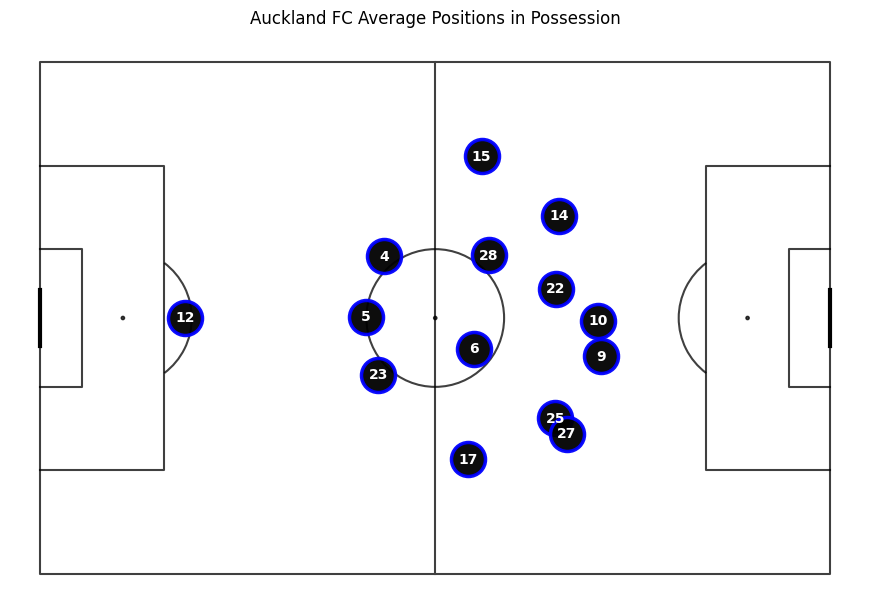

In [28]:
# Visualizing the data on a pitch

pitch = Pitch(
    pitch_type="skillcorner",
    line_alpha=0.75,
    pitch_length=105,
    pitch_width=68,
    pitch_color="white",
    line_color="black",
    linewidth=1.5,
)
fig, ax = pitch.grid(figheight=8, endnote_height=0, title_height=0)


# What to visualize
possession = "OOP"  # or 'OOP'
possession = "IP"
team = aggregated_df.team_name.unique().tolist()[
    0
]  # Pick one team, you can use the name directly

viz_ip = aggregated_df[
    (aggregated_df["possession_flag"] == possession)
    & (aggregated_df["team_name"] == team)
].reset_index(drop=True)


ax.scatter(
    viz_ip["x"],
    viz_ip["y"],
    c="black",
    alpha=0.95,
    s=600,
    edgecolors="blue",
    linewidths=2.5,
    zorder=10,
    label="team",
)


# Annotate player numbers
for i, row in viz_ip.iterrows():
    ax.text(
        row["x"],
        row["y"],
        str(row["number"]),
        color="white",
        fontweight="bold",
        fontsize=10,
        ha="center",
        va="center",
        zorder=16,
    )

ax.set_title(f"{team} Average Positions in Possession")

# fig.savefig("my_visualised_tracking_data.png", dpi=300, format="png")

In [21]:
filtered_df.head(5)

,x,y,player_id,is_detected,frame,timestamp,period,possession_player_id,possession_group,ball_x,...,player_role.position_group,total_time,player_role.name,player_role.acronym,is_gk,direction_player_1st_half,direction_player_2nd_half,direction_player,possession_team_name,possession_flag
396,-40.71,-0.27,51009,False,28,2025-12-03 00:00:01.800,1.0,966120.0,away team,0.03,...,Other,5400,Goalkeeper,GK,True,left_to_right,right_to_left,left_to_right,Newcastle United Jets FC,IP
397,-19.33,-9.63,176224,True,28,2025-12-03 00:00:01.800,1.0,966120.0,away team,0.03,...,Central Defender,5400,Right Center Back,RCB,False,left_to_right,right_to_left,left_to_right,Newcastle United Jets FC,IP
398,-21.72,0.22,51649,True,28,2025-12-03 00:00:01.800,1.0,966120.0,away team,0.03,...,Central Defender,5400,Left Center Back,LCB,False,left_to_right,right_to_left,left_to_right,Newcastle United Jets FC,IP
399,-0.64,-33.03,50983,True,28,2025-12-03 00:00:01.800,1.0,966120.0,away team,0.03,...,Full Back,5400,Right Back,RB,False,left_to_right,right_to_left,left_to_right,Newcastle United Jets FC,IP
400,-20.11,15.75,735578,True,28,2025-12-03 00:00:01.800,1.0,966120.0,away team,0.03,...,Full Back,5400,Left Back,LB,False,left_to_right,right_to_left,left_to_right,Newcastle United Jets FC,IP


In [22]:
filtered_df["possession_flag"].value_counts()

possession_flag
IP     346742
OOP    346742
Name: count, dtype: int64

### Dynamic Events

In [32]:
match_id = 1886347
de_match = pd.read_csv(f"https://raw.githubusercontent.com/SkillCorner/opendata/master/data/matches/{match_id}/{match_id}_dynamic_events.csv")

In [33]:
de_match.head(10)

,event_id,index,match_id,frame_start,frame_end,frame_physical_start,time_start,time_end,minute_start,second_start,...,xloss_player_possession_end,xloss_player_possession_max,xshot_player_possession_start,xshot_player_possession_end,xshot_player_possession_max,is_player_possession_start_matched,is_player_possession_end_matched,is_previous_pass_matched,is_pass_reception_matched,fully_extrapolated
0,8_0,0,1886347,28,28,NaN,00:01.8,00:01.8,0,1,...,NaN,NaN,NaN,NaN,NaN,True,True,NaN,True,False
1,8_1,1,1886347,48,58,NaN,00:03.8,00:04.8,0,3,...,NaN,NaN,NaN,NaN,NaN,True,True,True,True,False
2,7_0,2,1886347,48,53,NaN,00:03.8,00:04.3,0,3,...,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,False
3,7_1,3,1886347,48,58,NaN,00:03.8,00:04.8,0,3,...,NaN,NaN,NaN,NaN,NaN,True,True,NaN,True,False
4,9_0,4,1886347,56,58,34.0,00:02.4,00:04.8,0,2,...,NaN,NaN,NaN,NaN,NaN,True,True,True,True,NaN
5,8_2,5,1886347,72,89,NaN,00:06.2,00:07.9,0,6,...,NaN,NaN,NaN,NaN,NaN,True,True,True,True,False
6,7_2,6,1886347,72,82,NaN,00:06.2,00:07.2,0,6,...,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,False
7,7_3,7,1886347,72,89,NaN,00:06.2,00:07.9,0,6,...,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,False
8,7_4,8,1886347,72,89,NaN,00:06.2,00:07.9,0,6,...,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,False
9,7_5,9,1886347,73,89,NaN,00:06.3,00:07.9,0,6,...,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,False


In [34]:
de_match.loc[de_match["index"] >= 13, :].head(5)

,event_id,index,match_id,frame_start,frame_end,frame_physical_start,time_start,time_end,minute_start,second_start,...,xloss_player_possession_end,xloss_player_possession_max,xshot_player_possession_start,xshot_player_possession_end,xshot_player_possession_max,is_player_possession_start_matched,is_player_possession_end_matched,is_previous_pass_matched,is_pass_reception_matched,fully_extrapolated
13,1_2,13,1886347,82,99,NaN,00:07.2,00:08.9,0,7,...,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN
14,8_3,14,1886347,202,229,NaN,00:19.2,00:21.9,0,19,...,NaN,NaN,NaN,NaN,NaN,True,True,NaN,True,False
15,7_6,15,1886347,202,229,NaN,00:19.2,00:21.9,0,19,...,NaN,NaN,NaN,NaN,NaN,True,True,NaN,True,False
16,1_3,16,1886347,207,217,NaN,00:19.7,00:20.7,0,19,...,NaN,NaN,NaN,NaN,NaN,True,True,NaN,True,NaN
17,7_7,17,1886347,228,229,NaN,00:21.8,00:21.9,0,21,...,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,True


In [35]:
specific_event = de_match[de_match.event_id == "1_2"][
    [
        "event_id",
        "index",
        "match_id",
        "player_id",
        "frame_start",
        "frame_end",
        "event_type",
        "team_id",
        "player_in_possession_id",
        "x_start",
        "y_start",
        "x_end",
        "y_end"
    ]
]

specific_event

,event_id,index,match_id,player_id,frame_start,frame_end,event_type,team_id,player_in_possession_id,x_start,y_start,x_end,y_end
13,1_2,13,1886347,966120,82,99,off_ball_run,1805,735578.0,15.51,6.38,19.96,13.36


In [36]:

synced = specific_event.merge(
    enriched_tracking_data,
    left_on=["frame_end"],
    right_on="frame",
    suffixes=("_event", "_tracking"),
)
synced

,event_id,index,match_id_event,player_id_event,frame_start,frame_end,event_type,team_id_event,player_in_possession_id,x_start,...,number,team_id_tracking,team_name,player_role.position_group,total_time,player_role.name,player_role.acronym,is_gk,direction_player_1st_half,direction_player_2nd_half
0,1_2,13,1886347,966120,82,99,off_ball_run,1805,735578.0,15.51,...,1,1805,Newcastle United Jets FC,Other,5400,Goalkeeper,GK,True,left_to_right,right_to_left
1,1_2,13,1886347,966120,82,99,off_ball_run,1805,735578.0,15.51,...,4,1805,Newcastle United Jets FC,Central Defender,5400,Right Center Back,RCB,False,left_to_right,right_to_left
2,1_2,13,1886347,966120,82,99,off_ball_run,1805,735578.0,15.51,...,15,1805,Newcastle United Jets FC,Central Defender,5400,Left Center Back,LCB,False,left_to_right,right_to_left
3,1_2,13,1886347,966120,82,99,off_ball_run,1805,735578.0,15.51,...,14,1805,Newcastle United Jets FC,Full Back,5400,Right Back,RB,False,left_to_right,right_to_left
4,1_2,13,1886347,966120,82,99,off_ball_run,1805,735578.0,15.51,...,33,1805,Newcastle United Jets FC,Full Back,5400,Left Back,LB,False,left_to_right,right_to_left
5,1_2,13,1886347,966120,82,99,off_ball_run,1805,735578.0,15.51,...,19,1805,Newcastle United Jets FC,Midfield,5098,Left Defensive Midfield,LDM,False,left_to_right,right_to_left
6,1_2,13,1886347,966120,82,99,off_ball_run,1805,735578.0,15.51,...,17,1805,Newcastle United Jets FC,Midfield,5400,Right Defensive Midfield,RDM,False,left_to_right,right_to_left
7,1_2,13,1886347,966120,82,99,off_ball_run,1805,735578.0,15.51,...,37,1805,Newcastle United Jets FC,Midfield,3615,Attacking Midfield,AM,False,left_to_right,right_to_left
8,1_2,13,1886347,966120,82,99,off_ball_run,1805,735578.0,15.51,...,7,1805,Newcastle United Jets FC,Wide Attacker,5098,Right Winger,RW,False,left_to_right,right_to_left
9,1_2,13,1886347,966120,82,99,off_ball_run,1805,735578.0,15.51,...,39,1805,Newcastle United Jets FC,Wide Attacker,5400,Left Winger,LW,False,left_to_right,right_to_left


In [39]:

synced["runner"] = synced.player_id_event == synced.player_id_tracking
synced["ball_carrier"] = synced.player_in_possession_id == synced.player_id_tracking
synced["tip"] = synced.team_id_event == synced.team_id_tracking # team in posession

with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(synced.loc[synced["ball_carrier"],:])

,event_id,index,match_id_event,player_id_event,frame_start,frame_end,event_type,team_id_event,player_in_possession_id,x_start,y_start,x_end,y_end,x,y,player_id_tracking,is_detected,frame,timestamp,period,possession_player_id,possession_group,ball_x,ball_y,ball_z,is_detected_ball,match_id_tracking,start_time,end_time,match_name,date_time,home_team.name,away_team.name,id,short_name,number,team_id_tracking,team_name,player_role.position_group,total_time,player_role.name,player_role.acronym,is_gk,direction_player_1st_half,direction_player_2nd_half,runner,ball_carrier,tip
4,1_2,13,1886347,966120,82,99,off_ball_run,1805,735578.0,15.51,6.38,19.96,13.36,-8.24,25.8,735578,True,99,2025-12-04 00:00:08.900,1.0,NaN,away team,10.87,20.01,3.29,True,1886347,00:00:00,None,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,735578,M. Natta,33,1805,Newcastle United Jets FC,Full Back,5400,Left Back,LB,False,left_to_right,right_to_left,False,True,True


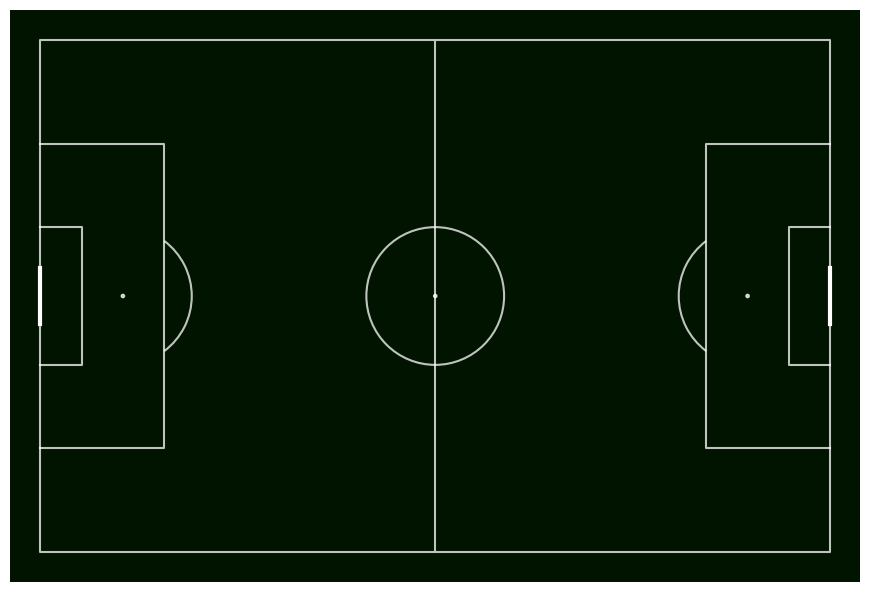

In [40]:
pitch = Pitch(
    pitch_type="skillcorner",
    line_alpha=0.75,
    pitch_length=105,
    pitch_width=68,
    pitch_color="#001400",
    line_color="white",
    linewidth=1.5,
)

fig, ax = pitch.grid(figheight=8, endnote_height=0, title_height=0)

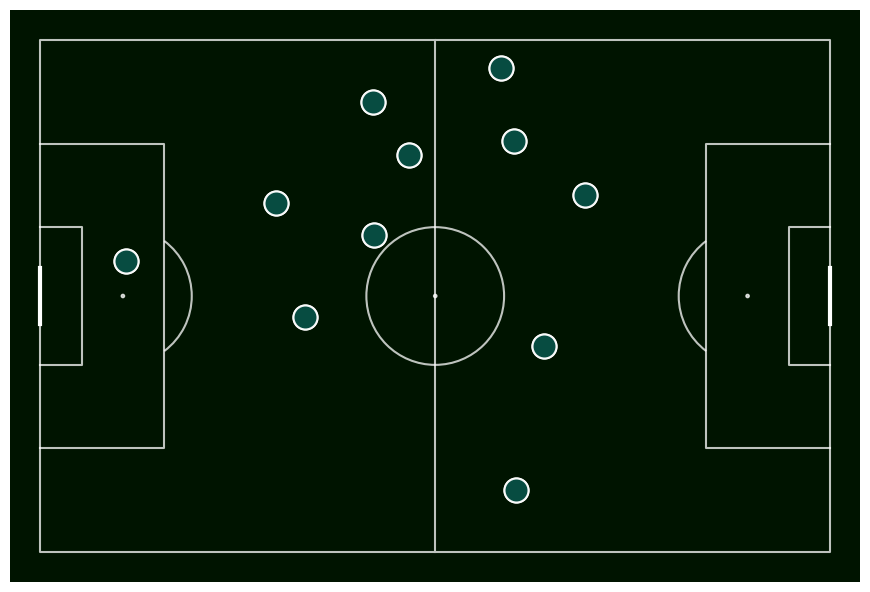

In [42]:
size = 300
possession_team = synced[synced.tip == True]
ax.scatter(
    possession_team["x"],
    possession_team["y"],
    c="#084D42",
    alpha=0.95,
    s=size,
    edgecolors="white",
    linewidths=1.5,
    zorder=10,
    label="team",
)

fig

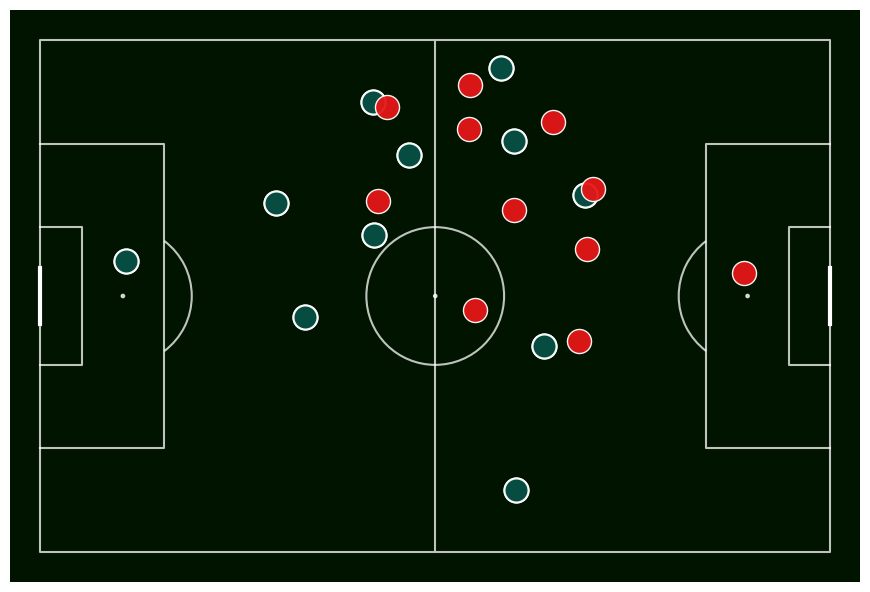

In [43]:

out_of_possession_team = synced[synced.tip == False]
ax.scatter(
    out_of_possession_team["x"],
    out_of_possession_team["y"],
    c="#E51717",
    alpha=0.95,
    s=size,
    edgecolors="white",
    linewidths=1,
    zorder=10,
    label="team",
)
fig

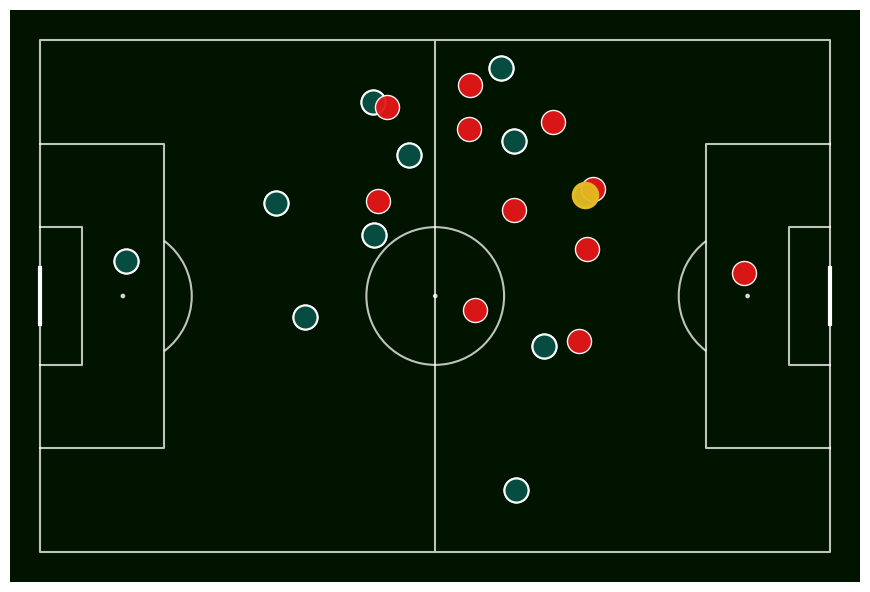

In [44]:

runner = synced[synced.runner == True]
ax.scatter(
    runner["x"],
    runner["y"],
    c="#E5BA21",
    alpha=0.95,
    s=size,
    edgecolors="#E5BA21",
    linewidths=2.5,
    zorder=10,
    label="team",
)
fig

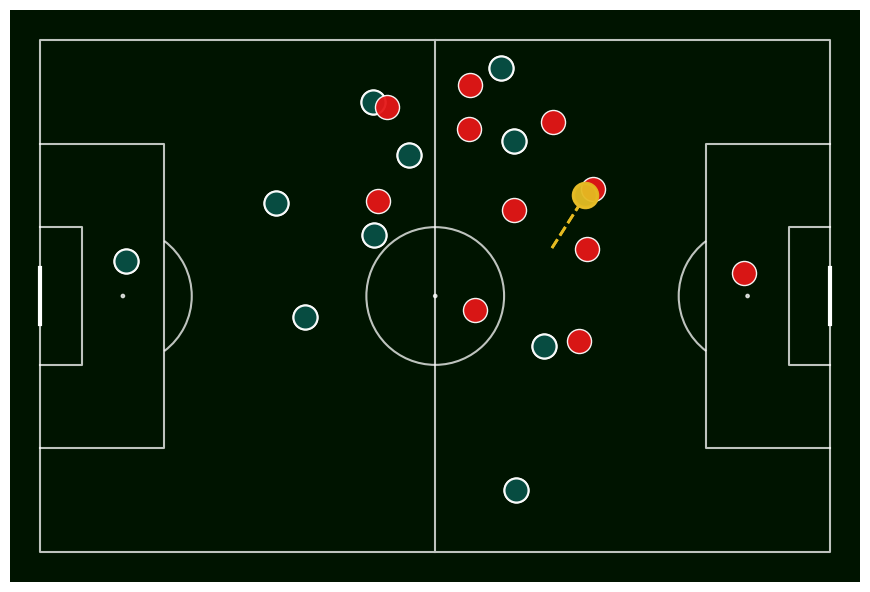

In [46]:

# Running
ax.plot(
    [runner["x_start"], runner["x"]],
    [runner["y_start"], runner["y"]],
    color="#E5BA21",
    linewidth=2,
    ls="--",
)
fig

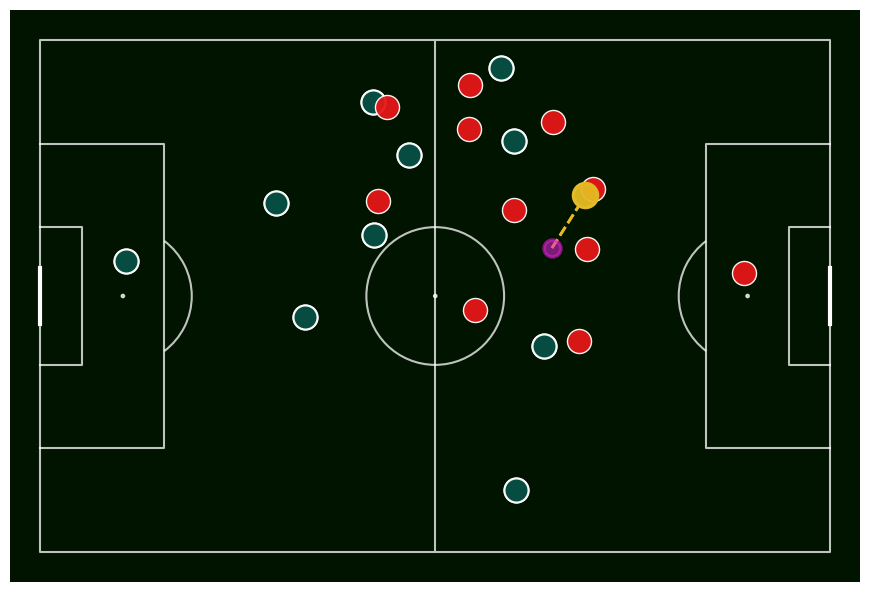

In [47]:

ax.scatter(
    runner["x_start"],
    runner["y_start"],
    c="#E521DB",
    alpha=0.55,
    s=size / 2,
    edgecolors="#E521DB",
    linewidths=2.5,
    zorder=10,
    label="team",
)
fig

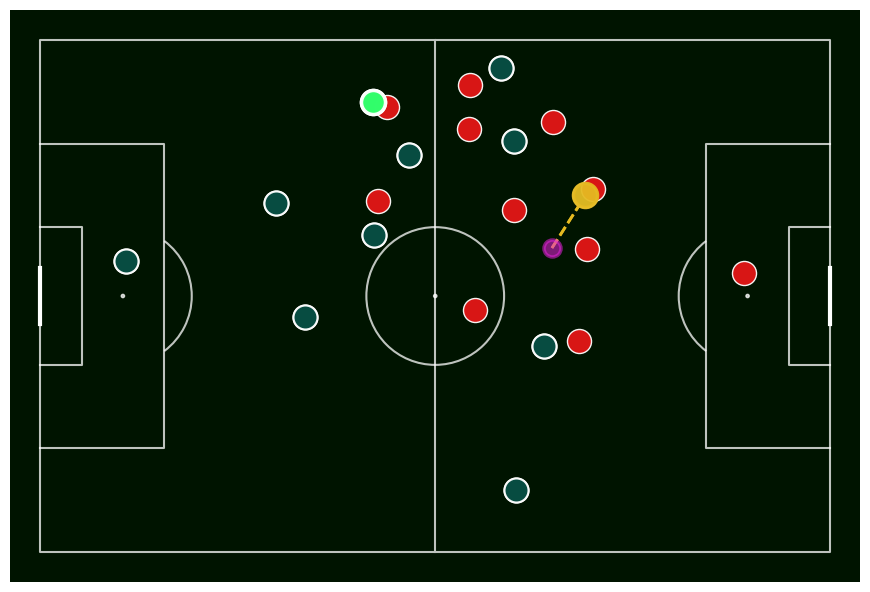

In [49]:

ball_carrier = synced[synced.ball_carrier == True]
ax.scatter(
    ball_carrier["x"],
    ball_carrier["y"],
    c="#32FE6B",
    alpha=0.95,
    s=size,
    edgecolors="white",
    linewidths=2.5,
    zorder=10,
    label="team",
)
fig

In [52]:
de_match[["event_type", "event_type_id"]].drop_duplicates()

,event_type,event_type_id
0,player_possession,8
2,passing_option,7
4,on_ball_engagement,9
10,off_ball_run,1


In [63]:
display(de_match["event_type"].value_counts())
display(100 * de_match["event_type"].value_counts() / (de_match.shape[0]))

event_type
passing_option        2544
player_possession      999
on_ball_engagement     937
off_ball_run           599
Name: count, dtype: int64

event_type
passing_option        50.088600
player_possession     19.669226
on_ball_engagement    18.448513
off_ball_run          11.793660
Name: count, dtype: float64

np.float64(100.0)

In [86]:
def missingness_DE_variables(event_df, event_type, write_to_csv : str = False):
    "Takes in the skill corner event data and identifies missingness for each variable"

    num_obs = event_df.loc[event_df["event_type"] == event_type, :].shape[0]

    # count the number of missing values for each variable then divide by the number of observations
    variables_df = pd.DataFrame((100 * event_df.loc[event_df["event_type"] == event_type, :]
                              .isna()
                              .sum() 
                              / num_obs)
                              .sort_values(ascending=True))
    
    variables_df = variables_df.reset_index() # to convert the row names into a column
    variables_df.columns = ["variable", "missing_percentage"]

    if write_to_csv:
        variables_df.to_csv(write_to_csv + "missing_data_" + event_type + ".csv", index = False)
        
    return variables_df

pp_missing = missingness_DE_variables(event_df = de_match, event_type = "player_possession", write_to_csv = "results/")
po_missing = missingness_DE_variables(event_df = de_match, event_type = "passing_option", write_to_csv = "results/")
obe_missing = missingness_DE_variables(event_df = de_match, event_type = "on_ball_engagement", write_to_csv = "results/")
obr_missing = missingness_DE_variables(event_df = de_match, event_type = "off_ball_run", write_to_csv = "results/")

In [ ]:
# Define global variables used in our helper functions
# these are columns relevant for the player in possession skill corner event
pp_columns = [
    "event_id", # match specific event id
    "associated_player_possession_event_id",
    # "match_id",
    "index", # sequence to order the events within a match, a tie for two events is broken using the event_id as prefix
    # "frame_start",
    # "frame_end",
    "event_type",
    
    
    "player_id",
    "player_name",
    "player_in_possession_id", # this identifies who the player in possession is
    "player_in_possession_name",
    "team_id",

    "time_start", # start time of the event
    "time_end", # end time of the event (will be crucial for possession analytics
    "duration",

    # "event_type",
    # Event characteristics
    "start_type",
    "end_type",
    # game interruptions (do we need them?)

    # Location information
    "x_start",
    "y_start",
    "x_end",
    "y_end",
    
    "channel_start", # which channel the event starts
    "third_start", # which third the event starts

    # previous pass information
    "pass_angle_received",
    "pass_direction_received",
    "pass_distance_received",
    "pass_range_received",

    # next pass (if any) information
    "pass_outcome",
    "targeted_passing_option_event_id",
    "high_pass",

    # movement by player
    "distance_covered",
    "trajectory_angle",
    "speed_avg", # The average speed of a player during the event (km/h) when he is detected on screen
    # there are other metrics like in to out/out to in (that describe how much they moved!!)


    # team and match information
    "game_state",
    "team_in_possession_phase_type",
    "team_out_of_possession_phase_type",

    # Separation statistics (separation_gain)
    # Line breaks (n_defensive_lines)
    # Possession characteristics like carry and one touch plays
    # Passing Options metrics also available

    
]

def processEvents(event_df, event_type):
    if event_type == "player_possession":
        output_df = event_df.loc[event_df["event_type"] == event_type, :].reset_index(drop = True)
        output_df = output_df[pp_columns].reset_index(drop = True)

        
    return output_df

In [154]:
explore_cols = [
    "index",
    "event_id",
    "event_type",
    "duration",
    "player_name",
    "player_in_possession_name",
    "associated_player_possession_event_id",
    "team_shortname",
    "targeted_passing_option_event_id",
    "player_targeted_name",

    
    "start_type",
    "end_type",
    "pass_outcome",
    "pass_distance",
    "team_possession_loss_in_phase",
    "first_player_possession_in_team_possession",
    "last_player_possession_in_team_possession"

]


with pd.option_context('display.max_rows', 40, 'display.max_columns', None): 
    display(de_match.loc[de_match["event_type"].isin(["player_possession", "passing_option"]),:][explore_cols].head(25))


,index,event_id,event_type,duration,player_name,player_in_possession_name,associated_player_possession_event_id,team_shortname,targeted_passing_option_event_id,player_targeted_name,start_type,end_type,pass_outcome,pass_distance,team_possession_loss_in_phase,first_player_possession_in_team_possession,last_player_possession_in_team_possession
0,0,8_0,player_possession,0.0,B. Gibson,NaN,NaN,Newcastle,NaN,A. Šušnjar,unknown,pass,successful,26.02,False,True,False
1,1,8_1,player_possession,1.0,A. Šušnjar,NaN,NaN,Newcastle,7_1,M. Natta,pass_reception,pass,successful,12.30,False,False,False
2,2,7_0,passing_option,0.5,K. Grozos,A. Šušnjar,8_1,Newcastle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,7_1,passing_option,1.0,M. Natta,A. Šušnjar,8_1,Newcastle,NaN,NaN,NaN,NaN,NaN,12.30,NaN,NaN,NaN
5,5,8_2,player_possession,1.7,M. Natta,NaN,NaN,Newcastle,7_4,B. Gibson,pass_reception,pass,unsuccessful,NaN,True,False,True
6,6,7_2,passing_option,1.0,C. Timmins,M. Natta,8_2,Newcastle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,7_3,passing_option,1.7,L. Bayliss,M. Natta,8_2,Newcastle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,7_4,passing_option,1.7,B. Gibson,M. Natta,8_2,Newcastle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,7_5,passing_option,1.6,T. Aquilina,M. Natta,8_2,Newcastle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,14,8_3,player_possession,2.7,N. Pijnaker,NaN,NaN,Auckland FC,7_6,F. De Vries,free_kick_reception,pass,successful,17.90,False,True,False


In [155]:
de_match[explore_cols].iloc[69:85,:]

,index,event_id,event_type,duration,player_name,player_in_possession_name,associated_player_possession_event_id,team_shortname,targeted_passing_option_event_id,player_targeted_name,start_type,end_type,pass_outcome,pass_distance,team_possession_loss_in_phase,first_player_possession_in_team_possession,last_player_possession_in_team_possession
69,69,7_35,passing_option,0.0,A. Paulsen,C. Elliott,8_14,Auckland FC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,70,9_10,on_ball_engagement,2.0,L. Bayliss,F. Gallegos,8_15,Newcastle,NaN,F. Gallegos,NaN,NaN,NaN,NaN,True,NaN,NaN
71,71,8_15,player_possession,1.6,F. Gallegos,NaN,NaN,Auckland FC,7_37,J. Brimmer,throw_in_reception,pass,successful,3.30,True,False,False
72,72,7_36,passing_option,0.4,L. Verstraete,F. Gallegos,8_15,Auckland FC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,73,7_37,passing_option,1.2,J. Brimmer,F. Gallegos,8_15,Auckland FC,NaN,NaN,NaN,NaN,NaN,3.30,NaN,NaN,NaN
74,74,1_9,off_ball_run,0.7,L. Rogerson,F. Gallegos,8_15,Auckland FC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,75,7_38,passing_option,0.6,C. Elliott,F. Gallegos,8_15,Auckland FC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,76,7_39,passing_option,0.3,L. Rogerson,F. Gallegos,8_15,Auckland FC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,77,9_11,on_ball_engagement,0.2,C. Timmins,F. Gallegos,8_15,Newcastle,NaN,F. Gallegos,NaN,NaN,NaN,NaN,True,NaN,NaN
78,78,7_40,passing_option,0.0,L. Verstraete,F. Gallegos,8_15,Auckland FC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [181]:
def getSequenceEvents(event_df):
    pp_events = event_df.loc[event_df["event_type"] == "player_possession",:][explore_cols].reset_index(drop = True)
    po_events = event_df.loc[event_df["event_type"] == "passing_option",:][explore_cols]
    po_events = po_events.loc[po_events["event_id"].isin(pp_events["targeted_passing_option_event_id"]), :].reset_index(drop = True)

    output_df = pd.concat([pp_events])#, po_events])
    output_df = output_df.sort_values(["index", "event_id"], ascending = True).reset_index(drop = True)

    return output_df

grah = getSequenceEvents(event_df=de_match)
grah.head(25)

,index,event_id,event_type,duration,player_name,player_in_possession_name,associated_player_possession_event_id,team_shortname,targeted_passing_option_event_id,player_targeted_name,start_type,end_type,pass_outcome,pass_distance,team_possession_loss_in_phase,first_player_possession_in_team_possession,last_player_possession_in_team_possession
0,0,8_0,player_possession,0.0,B. Gibson,NaN,NaN,Newcastle,NaN,A. Šušnjar,unknown,pass,successful,26.02,False,True,False
1,1,8_1,player_possession,1.0,A. Šušnjar,NaN,NaN,Newcastle,7_1,M. Natta,pass_reception,pass,successful,12.30,False,False,False
2,5,8_2,player_possession,1.7,M. Natta,NaN,NaN,Newcastle,7_4,B. Gibson,pass_reception,pass,unsuccessful,NaN,True,False,True
3,14,8_3,player_possession,2.7,N. Pijnaker,NaN,NaN,Auckland FC,7_6,F. De Vries,free_kick_reception,pass,successful,17.90,False,True,False
4,19,8_4,player_possession,0.8,F. De Vries,NaN,NaN,Auckland FC,7_10,L. Gillion,pass_reception,pass,unsuccessful,NaN,True,False,True
5,24,8_5,player_possession,1.6,D. Ingham,NaN,NaN,Newcastle,7_14,C. Timmins,pass_interception,pass,unsuccessful,NaN,True,True,True
6,31,8_6,player_possession,3.6,L. Gillion,NaN,NaN,Auckland FC,7_15,F. Gallegos,pass_interception,pass,successful,4.95,True,True,False
7,39,8_7,player_possession,0.0,F. Gallegos,NaN,NaN,Auckland FC,7_18,G. May,pass_reception,pass,unsuccessful,NaN,True,False,True
8,42,8_8,player_possession,4.3,R. Scott,NaN,NaN,Newcastle,NaN,M. Natta,recovery,pass,successful,19.51,False,True,False
9,43,8_9,player_possession,0.9,M. Natta,NaN,NaN,Newcastle,7_20,A. Šušnjar,pass_reception,pass,successful,12.21,False,False,False


In [182]:

# grah["possession_boundary"] = (grah["team_possession_loss_in_phase"] == True).shift(fill_value=False).astype(int)
# grah["possession_id"] = grah["possession_boundary"].cumsum()


grah["possession_boundary"] = (grah["first_player_possession_in_team_possession"] == True).astype(int)
grah["possession_id"] = grah["possession_boundary"].cumsum().astype("str")
grah["possession_id_team"] = grah["team_shortname"].str.strip() + "_" + grah["possession_id"]

grah.head(25)

,index,event_id,event_type,duration,player_name,player_in_possession_name,associated_player_possession_event_id,team_shortname,targeted_passing_option_event_id,player_targeted_name,start_type,end_type,pass_outcome,pass_distance,team_possession_loss_in_phase,first_player_possession_in_team_possession,last_player_possession_in_team_possession,possession_boundary,possession_id,possession_id_team
0,0,8_0,player_possession,0.0,B. Gibson,NaN,NaN,Newcastle,NaN,A. Šušnjar,unknown,pass,successful,26.02,False,True,False,1,1,Newcastle_1
1,1,8_1,player_possession,1.0,A. Šušnjar,NaN,NaN,Newcastle,7_1,M. Natta,pass_reception,pass,successful,12.30,False,False,False,0,1,Newcastle_1
2,5,8_2,player_possession,1.7,M. Natta,NaN,NaN,Newcastle,7_4,B. Gibson,pass_reception,pass,unsuccessful,NaN,True,False,True,0,1,Newcastle_1
3,14,8_3,player_possession,2.7,N. Pijnaker,NaN,NaN,Auckland FC,7_6,F. De Vries,free_kick_reception,pass,successful,17.90,False,True,False,1,2,Auckland FC_2
4,19,8_4,player_possession,0.8,F. De Vries,NaN,NaN,Auckland FC,7_10,L. Gillion,pass_reception,pass,unsuccessful,NaN,True,False,True,0,2,Auckland FC_2
5,24,8_5,player_possession,1.6,D. Ingham,NaN,NaN,Newcastle,7_14,C. Timmins,pass_interception,pass,unsuccessful,NaN,True,True,True,1,3,Newcastle_3
6,31,8_6,player_possession,3.6,L. Gillion,NaN,NaN,Auckland FC,7_15,F. Gallegos,pass_interception,pass,successful,4.95,True,True,False,1,4,Auckland FC_4
7,39,8_7,player_possession,0.0,F. Gallegos,NaN,NaN,Auckland FC,7_18,G. May,pass_reception,pass,unsuccessful,NaN,True,False,True,0,4,Auckland FC_4
8,42,8_8,player_possession,4.3,R. Scott,NaN,NaN,Newcastle,NaN,M. Natta,recovery,pass,successful,19.51,False,True,False,1,5,Newcastle_5
9,43,8_9,player_possession,0.9,M. Natta,NaN,NaN,Newcastle,7_20,A. Šušnjar,pass_reception,pass,successful,12.21,False,False,False,0,5,Newcastle_5


In [183]:
display(grah["possession_id_team"].nunique())

display(grah.loc[grah["team_shortname"] == "Auckland FC",:]["possession_id_team"].nunique())
display(grah.loc[grah["team_shortname"] == "Newcastle",:]["possession_id_team"].nunique())

212

106

106

In [184]:
grah["possession_id"].value_counts()

possession_id
13     40
72     28
211    24
110    24
197    20
       ..
112     1
106     1
99      1
95      1
212     1
Name: count, Length: 212, dtype: int64

In [196]:
x = grah.groupby(["possession_id"]).agg({"duration" : "sum"}).reset_index(drop = False)
x["possession_id_int"] = (x["possession_id"]).astype("int")

x.sort_values("possession_id_int", ascending = True)

,possession_id,duration,possession_id_int
0,1,2.7,1
111,2,3.5,2
135,3,1.6,3
146,4,3.6,4
157,5,8.7,5
...,...,...,...
121,208,0.0,208
122,209,8.1,209
124,210,4.0,210
125,211,29.9,211


In [185]:
grah.loc[grah["possession_id"] == "13",:]

,index,event_id,event_type,duration,player_name,player_in_possession_name,associated_player_possession_event_id,team_shortname,targeted_passing_option_event_id,player_targeted_name,start_type,end_type,pass_outcome,pass_distance,team_possession_loss_in_phase,first_player_possession_in_team_possession,last_player_possession_in_team_possession,possession_boundary,possession_id,possession_id_team
42,208,8_42,player_possession,0.0,M. Natta,NaN,NaN,Newcastle,7_102,T. Aquilina,pass_interception,pass,successful,11.84,False,True,False,1,13,Newcastle_13
43,212,8_43,player_possession,1.5,T. Aquilina,NaN,NaN,Newcastle,7_104,M. Natta,pass_reception,pass,successful,5.70,False,False,False,0,13,Newcastle_13
44,217,8_44,player_possession,0.7,M. Natta,NaN,NaN,Newcastle,7_107,K. Grozos,pass_reception,pass,successful,7.89,False,False,False,0,13,Newcastle_13
45,221,8_45,player_possession,1.7,K. Grozos,NaN,NaN,Newcastle,7_110,P. Cancar,pass_reception,pass,successful,15.66,False,False,False,0,13,Newcastle_13
46,229,8_46,player_possession,2.5,P. Cancar,NaN,NaN,Newcastle,7_112,D. Ingham,pass_reception,pass,successful,13.82,False,False,False,0,13,Newcastle_13
47,234,8_47,player_possession,0.0,D. Ingham,NaN,NaN,Newcastle,7_114,P. Cancar,pass_reception,pass,successful,16.08,False,False,False,0,13,Newcastle_13
48,239,8_48,player_possession,1.1,P. Cancar,NaN,NaN,Newcastle,7_117,A. Šušnjar,pass_reception,pass,successful,16.42,False,False,False,0,13,Newcastle_13
49,246,8_49,player_possession,1.3,A. Šušnjar,NaN,NaN,Newcastle,7_120,P. Cancar,pass_reception,pass,successful,5.98,False,False,False,0,13,Newcastle_13
50,252,8_50,player_possession,0.0,P. Cancar,NaN,NaN,Newcastle,7_123,R. Scott,pass_reception,pass,successful,16.12,False,False,False,0,13,Newcastle_13
51,255,8_51,player_possession,0.7,R. Scott,NaN,NaN,Newcastle,7_126,M. Natta,pass_reception,pass,successful,15.29,False,False,False,0,13,Newcastle_13


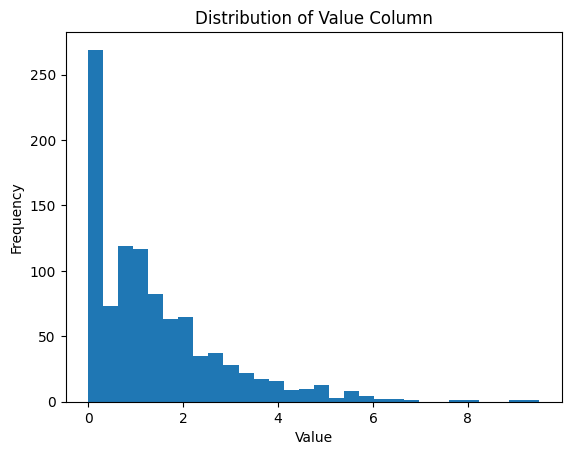

In [199]:
import matplotlib.pyplot as plt

grah["duration"].plot.hist(bins=30, title='Distribution of Value Column')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [197]:
grah["duration"].describe()

count    999.000000
mean       1.373974
std        1.427831
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        9.500000
Name: duration, dtype: float64